In [1]:
import numpy as np
import os 
import torch
import logging
from tqdm import tqdm

/n/fs/nlp-jiatongy/miniconda3/envs/.venv-22fall/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model_util import load_model
from data_util import load_data
from eval import load_data_pair
handlers = [logging.StreamHandler()]
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO,
                    handlers=handlers)
logger = logging.getLogger(__name__)

launched eval pipeline.


In [3]:
from eval import eval_bleu, eval_simcse,eval_tfidf

Support  
gpt2-xl normal: 500 sample  
gpt2-large normal: 800 sample  
gpt2-medium normal: 800 sample  
opt-1.3b normal: 500 sample  
galactica-6.7b normal: 100 sample  
  
gpt2-xl adv: 400 sample  
gpt2-large adv: 400 sample  

In [ ]:
def load_data_pair(logger, data_path, gen_only = True ):
    """
    Load generation results, convert reference to prompt format. 
        data_path should contain res.npy and ref.npy files.
    
    TODO: if prompting method changed, this also need to be chagned.
    """
    logger.info(f"loading data from {data_path}")
    assert os.path.exists(data_path+"-res.npy")
    raw_generations = np.load(data_path+"-res.npy")
    raw_references = np.load(data_path+"-ref.npy",allow_pickle=True)

    assert len(raw_generations) == len(raw_references)
    
    labels=[]
    generations = []
    if gen_only:
        for gen in raw_generations:
            generations.append(gen.split(sep="Generation:")[1])
        
        for lab in raw_references:
            labels.append(lab["text"])

    else: 
        for data in raw_references:
            if len(data["summary"]) > 1:
                summary_chunck = data["summary"].split(sep="\n")[0].split(sep=". ")[0]+". "
                prefix = "Generate long article based on title and summary. Title: "
                prompt = prefix+data["title"]+" Summary: "+ summary_chunck+"Generation: "
            
            else: 
                prefix = "Generate a long article based on title. Title: "
                prompt = prefix+data["title"]+" Generation: "
            
            label = prompt+data["text"]
            labels.append(label)
        generations = raw_generations 
    
    
    assert(len(generations) == len(labels))
    return generations, labels

In [38]:
MODEL_NAME = "gpt2-xl"
if MODEL_NAME in ["galactica-1.3b","galactica-6.7b"]:
    NORMAL_PATH = f"baseline1/cc_news-output/{MODEL_NAME}-top-p"
else: 
    NORMAL_PATH = f"baseline1/cc_news-output/var_len/{MODEL_NAME}-300-FINAL"
    ADV_PATH = f"baseline1/cc_news-output/var_len/{MODEL_NAME}-300-adv"
    IN_CONTEXT_PATH = f"baseline1/cc_news-output/var_len/{MODEL_NAME}-300-INCONTEXT"
generations,labels = load_data_pair(logger,NORMAL_PATH)
print(len(generations))
print(len(labels))

12/17/2022 03:33:42 - INFO - __main__ -   loading data from baseline1/cc_news-output/var_len/gpt2-xl-300-FINAL


500
500


GPT2 xl normal path  
interesting_idx = [12,24,108]  
misaligned_idx = [48,49,]  
hallu_idx = [73,]  

In [40]:
generations[24]

' 2013 Previous article: Generating many years of history to surprise your customers\n\nThe most significant trends we recognized in 2013 include: Storage infrastructure is converged. The principles of cloud management are using cloud management and tools to reduce complexity, but without focusing on optimized scenarios. Image-based data management is becoming more mainstream, with cloud providers looking to use backend of large data warehouses and there are many independent service providers and cloud products using SQL for their data. Many cloud service providers are shifting from standard infrastructure solutions to using solid-state infrastructure. The use of mobile devices is bringing opportunity for cloud service providers to provide mobile services.\n\nThe most significant trends we recognized in 2013 include: Storage infrastructure is converged. The principles of cloud management are using cloud management and tools to reduce complexity, but without focusing on optimized scenar

In [34]:
score = eval_bleu(logger,generations,labels)

12/17/2022 03:27:59 - INFO - __main__ -   calculating bleu scores...
12/17/2022 03:28:00 - INFO - __main__ -   bleu score: {'bleu': 0.0685115015941992, 'precisions': [0.44487033160198, 0.17978952008375118, 0.11884526105058892, 0.10399586061610294], 'brevity_penalty': 0.3863799228989779, 'length_ratio': 0.5125749664469423, 'translation_length': 163841, 'reference_length': 319643}


In [35]:
score = eval_tfidf(logger, generations, labels )

12/17/2022 03:28:00 - INFO - __main__ -   calculating tf-idf score...
500it [00:01, 451.08it/s]
12/17/2022 03:28:02 - INFO - __main__ -   tf-idf score: 0.5087086118710316


In [36]:
%%capture
score = eval_simcse(logger,generations,labels)

12/17/2022 03:28:05 - INFO - __main__ -   calculating simCSE scores...


In [37]:
score 

0.77699935

In [25]:
%%capture 
eval_simcse(logger,generations,labels)

12/17/2022 03:22:25 - INFO - __main__ -   calculating simCSE scores...


In [32]:
from simCSE.simcse.tool import SimCSE
def eval_simcse_sent(logger, generation, label):
    simcse = SimCSE("princeton-nlp/sup-simcse-bert-base-uncased")
    scores = []
    gen_sent = generation.split(sep=". ")

    for gen in gen_sent:
        if len(gen)<10:
            continue 
        scores.append(float(simcse.similarity([gen],[label])[0]))
    
    return scores 

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def eval_tfidf_sent(logger, generation, label):
    """
    Return tf-idf score.
    """
    tfidf_vectorizer = TfidfVectorizer(use_idf=True)
    vectorizer = tfidf_vectorizer.fit(labels)

    scores = []
    gen_sent = generation.split(". ")
    for sent in gen_sent:
        if len(sent)>10:
            score = cosine_similarity(vectorizer.transform([sent]), vectorizer.transform([label]))
            scores.append(float(score[0]))

    return scores 

In [16]:
eval_tfidf_sent(logger,generations[48],labels[])

NameError: name 'eval_tfidf_bleu' is not defined

In [31]:
float(eval_simcse_sent(logger,generations[49],labels[49])[0])


100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


0.14196893572807312

In [42]:
%%capture
sent_scores = []
for gen,lab in zip(generations[:200], labels[:200]):
    sent_scores.append(eval_simcse_sent(logger,gen,lab))

In [72]:
sent_scores_tf = []
for gen,lab in zip(generations[:200], labels[:200]):
    sent_scores_tf.append(eval_tfidf_sent(logger,gen,lab))

In [73]:
final_tf_scores = []
for sc in sent_scores_tf: 
    if len(sc)>20:
        final_tf_scores.append(sc[:20])

In [56]:
final_sent_scores = []
for sc in sent_scores: 
    if len(sc)>20:
        final_sent_scores.append(sc[:20])

In [57]:
import pandas as pd 
pd.DataFrame(final_sent_scores)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.378254,0.293547,0.293547,0.394404,0.394404,0.298963,0.335509,0.335509,0.169818,0.169818,0.334598,0.334598,0.277469,0.277469,0.277469,0.389291,0.389291,0.389291,0.277469,0.277469
1,0.537064,0.126422,0.087340,0.267385,0.140454,0.399501,0.340495,0.350091,0.156097,0.220309,0.282142,0.396495,0.005361,0.541465,0.343532,0.073360,0.357454,0.333746,0.482074,0.197576
2,0.147047,0.450891,-0.030314,0.393488,0.440461,0.455026,0.497929,0.429943,0.287288,0.476111,0.116790,0.204356,-0.063638,-0.143371,0.545802,0.350485,-0.071406,0.195627,0.301751,0.220428
3,0.043717,0.370867,0.398658,0.342692,0.393219,0.340777,0.160062,0.144627,0.076276,0.279789,0.329293,0.144902,0.382381,0.115268,0.079782,0.513808,0.392136,0.305114,0.145267,-0.052638
4,0.324623,0.317727,-0.035203,-0.000761,0.017539,-0.001429,-0.029764,0.004882,0.076823,0.298681,0.031449,0.362463,0.147174,0.023294,0.015305,0.225682,0.200232,-0.029764,0.064730,0.294346
5,0.574269,0.536377,0.627481,0.383477,0.472633,0.355698,0.482774,0.363962,0.413586,0.486471,0.517983,0.557683,0.472214,0.515389,0.632411,0.621237,0.429325,0.409905,0.474163,0.544717
6,0.412136,0.488538,0.539093,0.503817,0.467150,0.504950,0.374685,0.290305,0.405226,0.394384,0.369650,0.443016,0.481944,0.498096,0.432673,0.410216,0.354121,0.467150,0.498096,0.432673
7,0.306990,0.509149,0.486819,0.311330,0.520142,0.504149,0.462884,0.115173,0.365604,0.434018,0.458695,0.448418,0.170622,0.268722,0.307055,0.332799,0.210451,0.268722,0.307055,0.268761
8,0.283367,0.085663,0.510142,0.197664,0.510142,0.235628,0.263386,0.001583,0.167160,0.204685,0.298081,0.499889,0.190845,0.499889,0.114877,0.316933,0.066492,0.168310,0.194742,0.168310
9,0.049115,-0.025107,0.704516,0.472377,0.261049,0.085540,-0.084390,-0.053884,0.644805,0.100713,0.159848,0.286988,0.263519,-0.024284,0.121783,-0.004726,0.055817,0.032252,0.016782,0.090500


In [62]:
x = [i for i in range(1,21)]
avg = np.average(final_sent_scores,axis=0)

In [63]:
std = np.std(final_sent_scores,axis=0)

In [64]:
import matplotlib.pyplot as plt 

<ErrorbarContainer object of 3 artists>

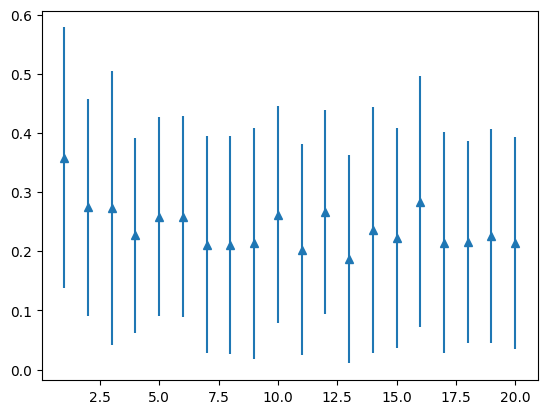

In [65]:
plt.errorbar(x, avg, std, linestyle='None', marker='^')

<ErrorbarContainer object of 3 artists>

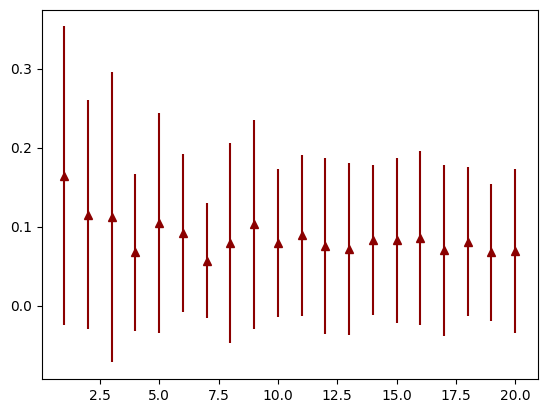

In [76]:
x = [i for i in range(1,21)]
avg = np.average(final_tf_scores,axis=0)
std = np.std(final_tf_scores,axis=0)
plt.errorbar(x, avg, std, linestyle='None', marker='^',color="darkred")